# Stack Overflow Analysis Part 1

## Introduction 

In this project, I have used some posts on Stack Overflow during the year of 2015 and measured the similarity of  users by looking at their answers' score. 

The data can be found here: [data dump](https://drive.google.com/a/bu.edu/file/d/0BzeSDLWpnNHxaEd5XzhIZ2tJMlU/view?usp=sharing) for Stack Overflow's posts in 2015. Note that the XML file is 10GB.

In [66]:
#File imports
import pandas as pd
import xml.etree.ElementTree as ET
import time
import csv
from collections import OrderedDict
from sklearn.feature_extraction.text import CountVectorizer
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [67]:
# Functions

startTime = time.time()
f = open('stackoverflow-posts-2015.xml', 'r', errors='replace')
content =  ET.iterparse(f, events=('end',))
contentIterator = iter(content)
dataCSV = open('stackoverflow_dataframe.csv','w')
csvwriter = csv.writer(dataCSV)
columns=['Id','CreationDate','OwnerUserId', 'ParentId','Tag','ViewCount','Score','Type']
csvwriter.writerow(columns)
errorCounter = 0
while True:
    try:
        event, elem = next(contentIterator)
    except UnicodeDecodeError:
        errorCounter += 1
        print('UnicodeDecodeError detected. Continuing parsing of file.')
        pass
    except StopIteration:
        print('End of iteration.')
        break
    try:
        if elem.tag == 'row':
            row = []
            row.append(elem.get('Id'))
            row.append(elem.get('CreationDate'))
            row.append(elem.get('OwnerUserId'))
            row.append(elem.get('ParentId'))
            Tags = elem.get('Tags')
            if Tags:    
                Tags = Tags.split('>')
                row.append(Tags[0][1:])
            else:
                row.append('None')
            row.append(elem.get('ViewCount'))
            row.append(elem.get('Score'))
            PostTypeId = elem.get('PostTypeId')
            if PostTypeId == '1':
                row.append('Q')
            else:
                row.append('A')
            csvwriter.writerow(row)
            elem.clear()
    except Exception as e:
        print(e)
        pass

dataCSV.close()
endTime = time.time()
print('Time taken to parse the file: ' + str(endTime - startTime))
print('Number of UnicodeDecodeErrors encountered: ' + str(errorCounter))

UnicodeDecodeError detected. Continuing parsing of file.
UnicodeDecodeError detected. Continuing parsing of file.
UnicodeDecodeError detected. Continuing parsing of file.
UnicodeDecodeError detected. Continuing parsing of file.
UnicodeDecodeError detected. Continuing parsing of file.
UnicodeDecodeError detected. Continuing parsing of file.
UnicodeDecodeError detected. Continuing parsing of file.
UnicodeDecodeError detected. Continuing parsing of file.
UnicodeDecodeError detected. Continuing parsing of file.
UnicodeDecodeError detected. Continuing parsing of file.
End of iteration.
Time taken to parse the file: 654.2530908584595
Number of UnicodeDecodeErrors encountered: 10


In [81]:
df = pd.read_csv('stackoverflow_dataframe.csv')
df = df[~df['OwnerUserId'].isnull()]
df = df.fillna('None')
print(df.info(null_counts=True))
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5732347 entries, 0 to 5751162
Data columns (total 8 columns):
Id              5732347 non-null float64
CreationDate    5732347 non-null object
OwnerUserId     5732347 non-null float64
ParentId        5732347 non-null object
Tag             5732347 non-null object
ViewCount       5732347 non-null object
Score           5732347 non-null float64
Type            5732347 non-null object
dtypes: float64(3), object(5)
memory usage: 393.6+ MB
None
           Id             CreationDate  OwnerUserId     ParentId   Tag  \
0  27727381.0  2015-01-01T00:00:27.040    1971096.0  2.84521e+06  None   
1  27727382.0  2015-01-01T00:00:31.240    2410359.0  2.77271e+07  None   
2  27727384.0  2015-01-01T00:00:50.550    1366219.0  2.77256e+07  None   
3  27727385.0  2015-01-01T00:00:58.253    3210431.0         None   php   
4  27727387.0  2015-01-01T00:01:43.597    3886175.0  1.19621e+07  None   

  ViewCount  Score Type  
0      None    6.0    A  
1      No

-----------------

In [94]:
df_ques = df[~(df['OwnerUserId'].isnull())&(df['Type']=='Q')][['Id', 'OwnerUserId', 'Tag']]
df_ans = df[~(df['OwnerUserId'].isnull())&(df['Type']=='A')][['Id', 'OwnerUserId', 'Score', 'ParentId']]
df_joined = pd.merge(df_ans, df_ques, left_on='ParentId', right_on='Id', suffixes=['_ans', '_ques'])
df_joined.head()

,Id_ans,OwnerUserId_ans,Score,ParentId,Id_ques,OwnerUserId_ques,Tag
0,27727421.0,871026.0,1.0,2.77274e+07,27727407.0,821742.0,java
1,27727426.0,3113558.0,0.0,2.77274e+07,27727419.0,347062.0,html
2,27727428.0,541091.0,0.0,2.77274e+07,27727410.0,541091.0,mysql
3,27727432.0,6216.0,2.0,2.77274e+07,27727394.0,4263870.0,php
4,27727515.0,1300892.0,0.0,2.77274e+07,27727394.0,4263870.0,php


In [99]:
df_top_users = df_joined.groupby(['OwnerUserId_ans'], as_index=False)[['Score']].sum()
df_top_users = df_top_users.sort_values('Score', ascending=False).reset_index(drop=True)
df_top_100_users = df_top_users[:100]
df_top_100_users.tail()

,OwnerUserId_ans,Score
95,139985.0,1654.0
96,5070879.0,1651.0
97,2372064.0,1646.0
98,3093378.0,1641.0
99,1064245.0,1638.0


In [96]:
df_tags = df_joined[df_joined['OwnerUserId_ans'].isin(df_top_100_users['OwnerUserId_ans'])][['OwnerUserId_ans', 'Tag']].reset_index(drop=True)
df_tags = df_tags.drop_duplicates()
top100UsersDict = {k: v['Tag'].tolist() for k,v in df_tags.groupby('OwnerUserId_ans')}
top100UsersTagsLists = []
tagsString = ', '
for OwnerUserId in top100UsersDict:
    top100UsersTagsLists.append(tagsString.join(top100UsersDict[OwnerUserId]))

['delphi, function, multithreading, c++, vb.net, python, c#, c, winapi, windows, android, mysql, forms, java, string, pinvoke, listview, excel, xml, lazarus, performance, arrays, editplus, json, 64bit, c#-4.0, osx, cmd, c++builder, matlab, dll, registry, class, file, sqlite, visual-studio-2013, list, git, .net, session, node.js, generics, interface, delphi-xe8, visual-studio, unit-testing, wpf, if-statement, r, database, dllimport, sockets, linux, swift, qt, algorithm, delphi-xe5, ios',
 'c++, c, arrays, c++11, templates',
 'javascript, c#, python, java, regex, php, ruby-on-rails, html, ruby, jquery, mysql, ios, asp.net, sql-server, sql, c++, .net, string, json, arrays, android',
 'php, mysql, angularjs, laravel, javascript, datetime, twitter-bootstrap, authentication, model-view-controller, regex, sqlite, ajax, validation, oop, arrays, testing, events, database, image, laravel-4, ubuntu, templates, jquery, apache, forms, redirect, sql, git, laravel-routing, laravel-5, blade, composer-

In [105]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(top100UsersTagsLists)
vectorsArray = vectors.toarray()
euclidean_dists = metrics.euclidean_distances(vectorsArray)
print('Similarity between the top 100 users:')
print(euclidean_dists)

Similarity between the top 100 users:
[[ 0.          8.66025404  8.88819442 ...,  9.11043358  9.43398113
   9.94987437]
 [ 8.66025404  0.          5.47722558 ...,  4.89897949  6.92820323
   7.61577311]
 [ 8.88819442  5.47722558  0.         ...,  6.32455532  6.4807407
   8.1240384 ]
 ..., 
 [ 9.11043358  4.89897949  6.32455532 ...,  0.          7.34846923
   7.74596669]
 [ 9.43398113  6.92820323  6.4807407  ...,  7.34846923  0.          8.94427191]
 [ 9.94987437  7.61577311  8.1240384  ...,  7.74596669  8.94427191  0.        ]]


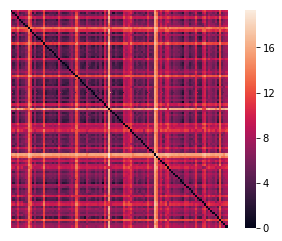

In [103]:
_ = sns.heatmap(euclidean_dists, xticklabels=False, yticklabels=False, linewidths=0,
            square=True,cbar=True)

Here the heatmap is used to visualize the similarity in types of question answered by top 100 users of stackoverflow of the year 2015 (calculated based on their answer scores). The heatmap is plotted using the euclidean distance between these users' 'tag' vectors. We can see that most users' vectors are similar, except for few. The distinct light colored lines show the most dissimilar users.

-----------------